In [1]:
from random import Random
from time import time
import numpy as np
import matplotlib.pyplot as plt

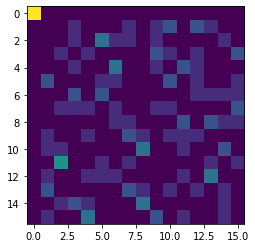

In [3]:
rand= Random()

#STANDARD

SBOX= [0xe, 0x4, 0xd, 0x1,0x2, 0xf, 0xb, 0x8, 0x3, 0xa, 0x6, 0xc, 0x5, 0x9, 0x0, 0x7]
INV_SBOX= [SBOX.index(i) for i in range(16)]

PBOX= [((4*i) %15) for i in range(15)] + [15]
INV_PBOX= [PBOX.index(i) for i in range(16)]

# create_new_key= lambda key, round: key^^round

tobits= lambda x, nbits: [*map(int, format(x, "0%db"%nbits)[::-1])]     # little endian
frombits= lambda y: sum(y[i]*(2^i) for i in range(len(y)))
def get_ddt(sbox):
    l= len(sbox)
    ddt= np.zeros((l,l), dtype=int)
    for i,x in enumerate(sbox):
        for j,y in enumerate(sbox):
            ddt[i^^j][x^^y]+= 1
    return ddt

DDT= get_ddt(SBOX)
plt.imshow(DDT)
plt.show()

In [6]:
def encrypt(plaintext, key): 
    cipher= plaintext
    for round in range(4):      # use 1 round less for probabilistic test of differential characteristic
        cipher ^^= key^^round 
        # print(hex(cipher))

        b= tobits(cipher, 16)
        for j in range(0, len(b), 4): b[j:j+4]= tobits(SBOX[frombits(b[j:j+4])], 4)
        # print(hex(frombits(b)))

        temp= [[]]*16
        for i in range(len(b)): temp[PBOX[i]]= b[i]
        b= temp
        cipher= frombits(b)
        # print(hex(cipher))
    
    cipher ^^= key^^4

    return cipher

In [10]:
# test_entry= 0x1234
# test_cipher= encrypt(test_entry, test_key)
# print(hex(test_cipher))

## Brute Force Differential Attack (differential given)

In [11]:
# highlight entire section to toggle comment
# BRUTE FORCE DIFFERENTIAL ATTACK (differential given)

test_key= rand.randint(0, 0xffff)
input_d= 0x0b00
e_output_d= 0x0606        # s-box 2 and 4, from msb
input_d1= 0xa0a0
e_output_d1= 0x8088      # s-box 1, 3, 4, from msb

# probabilistic test with actual key
# start_time= time()
# x= set(); m=[0]*2^8
# for entry in range(15000):
#     x1= rand.randint(0,0xffff)
#     while (x1 in x): x1= rand.randint(0,0xffff)
#     x2= x1^^input_d
#     x.add(x1); x.add(x2); 

#     y1= encrypt(x1, test_key)
#     y2= encrypt(x2, test_key)
    
#     y_diff= tobits(y1^^y2, 16)
#     cha= y_diff[0:4]+y_diff[8:12]
#     m[frombits(cha)]+=1

# print(hex(m.index(max(m))), (max(m)/15000).n())
# print(m)
# print(time()- start_time)

start_time= time()
x= set(); y=[0]*2^8

for entry in range(1000): 
    x1= rand.randint(0, 0xffff)
    while x1 in x: x1= rand.randint(0, 0xffff)
    x2= x1^^input_d
    x.add(x1); x.add(x2); 
    
    y1= encrypt(x1, test_key)
    y2= encrypt(x2, test_key)

    for out in range(2^8):
        temp= [[]]*16
        out_key= tobits(out,8); out_b= []; 
        for i in range(8): out_b+= [out_key[i]]+ [0]     # key-bits fitted due to choice of differential / s-boxes
        out_key= frombits(out_b)

        y1b= tobits(y1^^out_key, 16)
        for i in range(len(y1b)): temp[INV_PBOX[i]]= y1b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])],4)
        y1b= frombits(temp)

        y2b= tobits(y2^^out_key, 16)
        for i in range(len(y2b)): temp[INV_PBOX[i]]= y2b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])], 4)
        y2b= frombits(temp)

        y_diff= tobits(y1b^^y2b, 16)
        if frombits(y_diff)== e_output_d: y[out]+=1

obtained_bits= []
bt= tobits(y.index(max(y))^^2, 16)
for i in range(8): obtained_bits+= [bt[i]] +[0]

x= set(); y= [0]*2^8; 
for entry in range(1000):
    x1= rand.randint(0, 0xffff)
    while x1 in x: x1= rand.randint(0, 0xffff)
    x2= x1 ^^ input_d1
    x.add(x1); x.add(x2); 

    y1= encrypt(x1, test_key)
    y2= encrypt(x2, test_key)

    for out in range(2^8):
        temp= [[]]*16
        out_key= tobits(out, 8); out_b= []; 
        for i in range(8): out_b+= [obtained_bits[2*i]]+ [out_key[i]]
        out_key= frombits(out_b) ^^4

        y1b= tobits(y1^^out_key, 16)
        for i in range(len(y1b)): temp[INV_PBOX[i]]= y1b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])], 4)
        y1b= frombits(temp)

        y2b= tobits(y2^^out_key, 16)
        for i in range(len(y2b)): temp[INV_PBOX[i]]= y2b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])], 4)
        y2b= frombits(temp)

        y_diff= tobits(y1b^^y2b, 16)
        if frombits(y_diff)== e_output_d1: y[out]+=1

bt= tobits(y.index(max(y)), 16)
for i in range(8): obtained_bits[2*i+1]= bt[i]      # remaining bits
obtained_key= frombits(obtained_bits)

print(hex(obtained_key), hex(test_key))
print(time()-start_time)
# Success with 1000 pairs at ~45s

0x51f4 0x51f4
42.8469340801239


## Automatic Search pf Differential Characteristic

### Use Convex Hull (no optimization)

In [13]:
def get_sbox_hrep(sbox):
    ddt = get_ddt(sbox)
    l = len(sbox)
    lb = int(l).bit_length()-1
    assert l == 1<<lb   # each successive bit carries an extra weight of *2 => l= max(weight) of bits
    space = []
    for x in range(l):
        for y in range(l):
            if ddt[x,y] == 0: continue
            xb = tobits(x, lb)
            yb = tobits(y, lb)
            space.append((*xb, *yb))
    
    p = Polyhedron(vertices=space)
    return p.Hrepresentation()

In [14]:
def hrep_to_ineq(hrep, lin_var):
    assert len(lin_var) == len(hrep[0]) - 1
    # hrep includes constant b in iterable as element 0
    return [
        sum(var*coeff for coeff,var in zip([*ieq][1:], lin_var)) + ieq.b() >= 0 
        for ieq in hrep
    ]
    # 1.    The function pushes '*' multiply operator. MIP linear function (lf) 
    #       attaches real constants to variables for storage as lf object. 
    # 2.    '>=', __geq__ has been overwritten to read 2 lf and output some 
    #       linear constraint (lc), thus NOT a boolean
    # 3.    Returns a list of constraints

In [15]:
# Forming the MILP
hrep= get_sbox_hrep(SBOX)

solver= MixedIntegerLinearProgram(maximization=False)
vargen= solver.new_variable(integer= True)

pt= [vargen[i] for i in range(16)]  # generates a new variable point with each indexing imposed
ct= [vargen[i] for i in range(16, 32)]
active_s= [vargen[i] for i in range(32, 36)]

solver.set_objective(sum(active_s))

In [16]:
sboxcons= [
    hrep_to_ineq(
        hrep, 
        pt[n*4: n*4 +4] + ct[n*4: n*4+4])
    for n in range(4)
]   # generates constraints of 1 sbox and apply to all sboxes
for sc in sboxcons: 
    for c in sc: solver.add_constraint(c)

In [17]:
# identify active s-boxes
solver.add_constraint(sum(pt) >=1)    # only non-trivial solutions
for sbox in range(4):
    solver.add_constraint(active_s[sbox] <=1)     # boolean variable
for bit in range(len(pt)):
    solver.add_constraint(active_s[bit//4]>= pt[bit]) 

In [19]:
# solver.show()
min_s= solver.solve()
print(min_s)
d_in= solver.get_values(pt)
d_out= solver.get_values(ct)
print(d_in)
print(d_out)

1.0
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
